In [1]:
# inspired by this:
# https://www.kaggle.com/bguberfain/naive-keras-2

In [2]:
import base64
import collections
import copy
import cProfile
import datetime
import itertools
import json
import math
import os
import operator
import pickle
import random
import re
import shutil
import sys
import time

import cv2
import Image
import keras
from keras import *
from keras import backend as K
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import PIL as pil
import pylab
import scipy
import seaborn as sns
import skimage
import sklearn
from sklearn import *
import statsmodels as sm
import tensorflow as tf
import tqdm

np.random.seed(1337)

%matplotlib inline

sns.set(font_scale=1.3)
mpl.rcParams['figure.figsize'] = 20, 12
sns.set_style('whitegrid')
sns.set_palette(sns.color_palette('muted'))

linewidth = 1.0
dotsize = 15

Using TensorFlow backend.
/usr/local/lib/python2.7/dist-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/usr/local/lib/python2.7/dist-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)
/usr/local/lib/python2.7/dist-packages/sklearn/lda.py:6: DeprecationWarning: lda.LDA has been moved to discriminant_analysis.LinearDiscriminantAnalysis in 0.17 and will be removed in 0.19
  "in 0.17 and will be removed in 0.19", DeprecationWarning)
/usr/lo

In [3]:
data_dir = '/media/ntfs/data/carvana_masking'

input_dir = data_dir + '/input'
tmp_dir = data_dir + '/tmp'
output_dir = data_dir + '/output'

train_dir = input_dir + '/train'
train_mask_dir = input_dir + '/train_masks'

val_dir = input_dir + '/validation'
val_mask_dir = input_dir + '/validation_masks'

test_dir = input_dir + '/test'

In [4]:
angle = 1

resize_h = 160
resize_w = 240

n_train = 256  # max: 257
n_val = 32     # max: 61

batch_size = 16

epochs = 100

smooth = 1.0

In [5]:
train_ids = list(set([name[:12] for name in os.listdir(train_dir)]))
random.shuffle(train_ids)
train_ids = train_ids[:n_train]

val_ids = list(set([name[:12] for name in os.listdir(val_dir)]))
random.shuffle(val_ids)
val_ids = val_ids[:n_val]

In [6]:
def load_image(id, angle, val=False):
    
    dir = train_dir
    if val:
        dir = val_dir
        
    img = image.load_img(
            dir + '/{0}_{1:02d}.jpg'.format(id, angle),
            target_size=(resize_h, resize_w))
    img = image.img_to_array(img)
    return img

def load_mask(id, angle, val=False):
    dir = train_mask_dir
    if val:
        dir = val_mask_dir
        
    img = image.load_img(
            dir + '/{0}_{1:02d}_mask.gif'.format(id, angle),
            target_size=(resize_h, resize_w))
    img = image.img_to_array(img)
    img = img[:,:,0]
    return img

In [7]:
def load_data(n, angle=angle, val=False):
    
    dir = train_dir
    mask_dir = train_mask_dir
    ids = train_ids
    if val:
        dir = val_dir
        mask_dir = val_mask_dir
        ids = val_ids
    
    X = np.empty((n, resize_h, resize_w, 12), dtype=np.float32)
    y = np.empty((n, resize_h, resize_w, 1), dtype=np.float32)
    
    with tqdm.tqdm_notebook(total=n) as bar:
        
        for i in range(n):
            
            imgs = [load_image(ids[i], a, val) for a in range(1, 17)]
            X[i, ..., :9] = np.concatenate([imgs[angle-1], np.mean(imgs, axis=0), np.std(imgs, axis=0)], axis=2)
            y[i] = np.expand_dims(load_mask(ids[i], angle, val), 2) / 255.
            
            del imgs
            
            bar.update()
            
    return X, y

In [8]:
X_train, y_train = load_data(n_train)
X_val, y_val = load_data(n_val, val=True)

Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


In [9]:
y_train_mean = y_train.mean(axis=0)
y_train_std = y_train.std(axis=0)
y_train_min = y_train.min(axis=0)

y_features = np.concatenate([y_train_mean, y_train_std, y_train_min], axis=2)

X_train[:, ..., -3:] = y_features
X_val[:, ..., -3:] = y_features

In [10]:
X_mean = X_train.mean(axis=(0,1,2), keepdims=True)
X_std = X_train.std(axis=(0,1,2), keepdims=True)

X_train -= X_mean
X_train /= X_std

X_val -= X_mean
X_val /= X_std

(160, 240, 12)


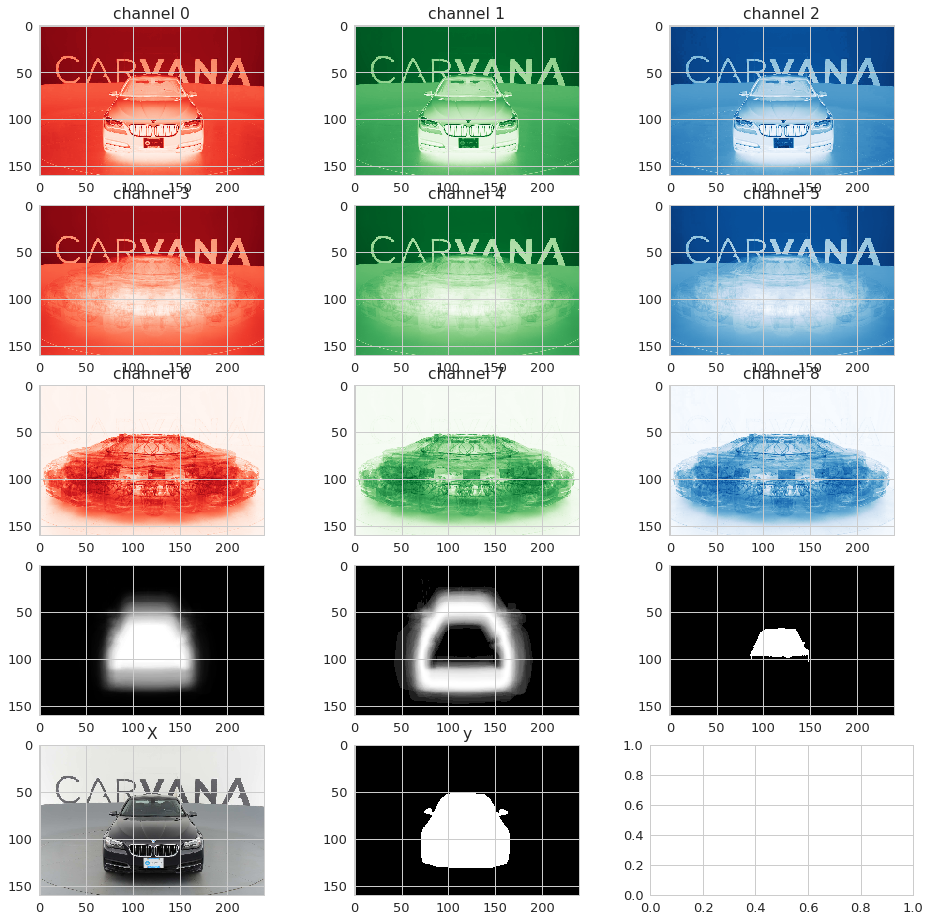

In [11]:
idx = 0
x = X_train[idx]
print x.shape

fig, ax = plt.subplots(5,3, figsize=(16, 16))
ax = ax.ravel()

cmaps = ['Reds', 'Greens', 'Blues']
for i in range(9):
    ax[i].imshow(x[...,i], cmaps[i%3])
    ax[i].set_title('channel {}'.format(i))

ax[-6].imshow(x[...,9], cmap='gray')
ax[-5].imshow(x[...,10], cmap='gray')
ax[-4].imshow(x[...,11], cmap='gray')
    
ax[-3].imshow((x[...,:3] * X_std[0,...,:3] + X_mean[0,...,:3]) / 255., cmap='gray')
ax[-3].set_title('X')

ax[-2].imshow(y_val[idx,...,0], cmap='gray')
ax[-2].set_title('y')


In [12]:
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def bce_dice_loss(y_true, y_pred):
    return 0.5 * keras.losses.binary_crossentropy(y_true, y_pred) - dice_coef(y_true, y_pred)

def dice_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

# Adding More Layers to Bruno's Model

In [13]:
inp = keras.layers.Input((resize_h, resize_w, 12))

conv1 = keras.layers.Conv2D(12, 3, activation='relu', padding='same')(inp)
conv2 = keras.layers.Conv2D(12, 3, activation='relu', padding='same')(inp)
max1 = keras.layers.MaxPooling2D(2)(conv2)

conv3 = keras.layers.Conv2D(12, 3, activation='relu', padding='same')(max1)
conv4 = keras.layers.Conv2D(12, 3, activation='relu', padding='same')(conv3)
max2 = keras.layers.MaxPooling2D(2)(conv4)

conv5 = keras.layers.Conv2D(12, 3, activation='relu', padding='same')(max2)

deconv4 = keras.layers.Conv2DTranspose(12, 3, strides=2, activation='relu', padding='same')(conv4)
deconv5 = keras.layers.Conv2DTranspose(12, 3, strides=4, activation='relu', padding='same')(conv5)

deconvs = keras.layers.concatenate([conv2, deconv4, deconv5])

out = keras.layers.Conv2D(1, 7, activation='sigmoid', padding='same')(deconvs)

model = keras.models.Model(inp, out)
print model.summary()

model.compile(keras.optimizers.Adam(lr=1e-3), dice_loss, metrics=['accuracy', dice_coef])

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 160, 240, 12)  0                                            
____________________________________________________________________________________________________
conv2d_2 (Conv2D)                (None, 160, 240, 12)  1308        input_1[0][0]                    
____________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)   (None, 80, 120, 12)   0           conv2d_2[0][0]                   
____________________________________________________________________________________________________
conv2d_3 (Conv2D)                (None, 80, 120, 12)   1308        max_pooling2d_1[0][0]            
___________________________________________________________________________________________

In [14]:
history = model.fit(
            x=X_train,
            y=y_train,
            epochs=epochs,
            validation_data=(X_val, y_val),
            batch_size=batch_size,
            verbose=0)

In [15]:
print '{0:0.4f}'.format(np.average(history.history['val_dice_coef'][-10:]))

0.9722


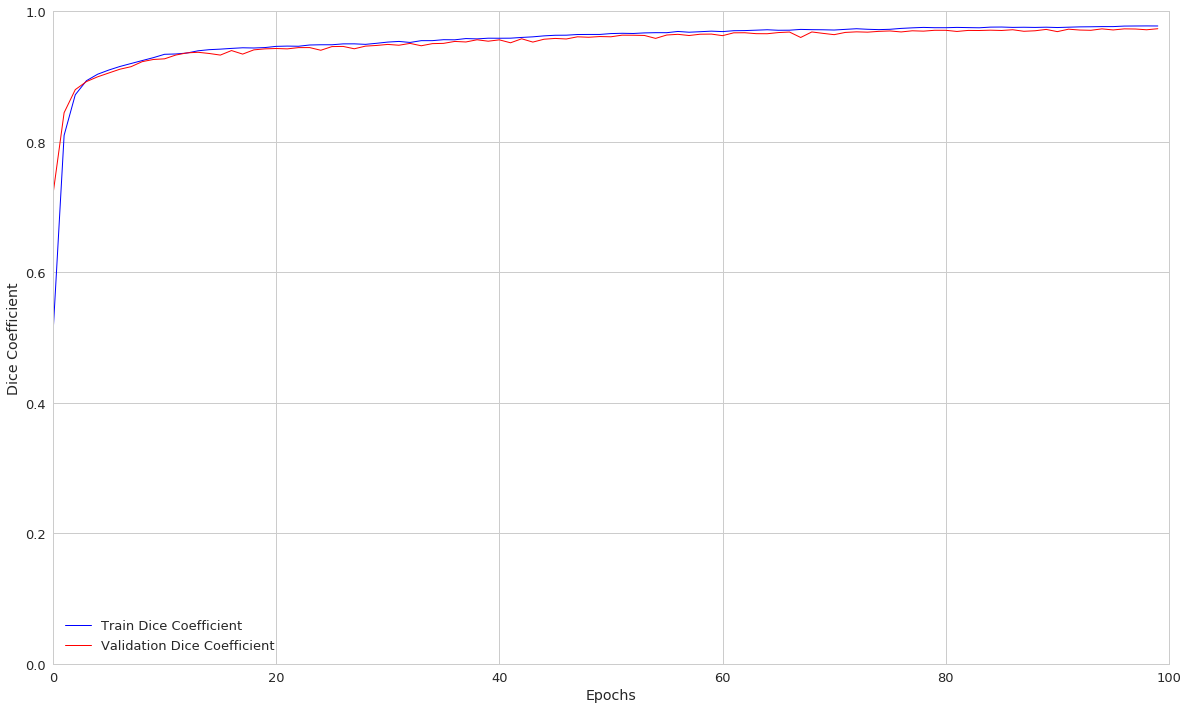

In [16]:
dice = history.history['dice_coef']
val_dice = history.history['val_dice_coef']

eps = range(len(dice))

_ = plt.plot(eps, dice, 'b', label='Train Dice Coefficient', linewidth=linewidth)
_ = plt.plot(eps, val_dice, 'r', label='Validation Dice Coefficient', linewidth=linewidth)

_ = plt.xlabel('Epochs')
_ = plt.ylabel('Dice Coefficient')

_ = plt.xlim((0, epochs))
_ = plt.ylim((0, 1))

_ = plt.legend()

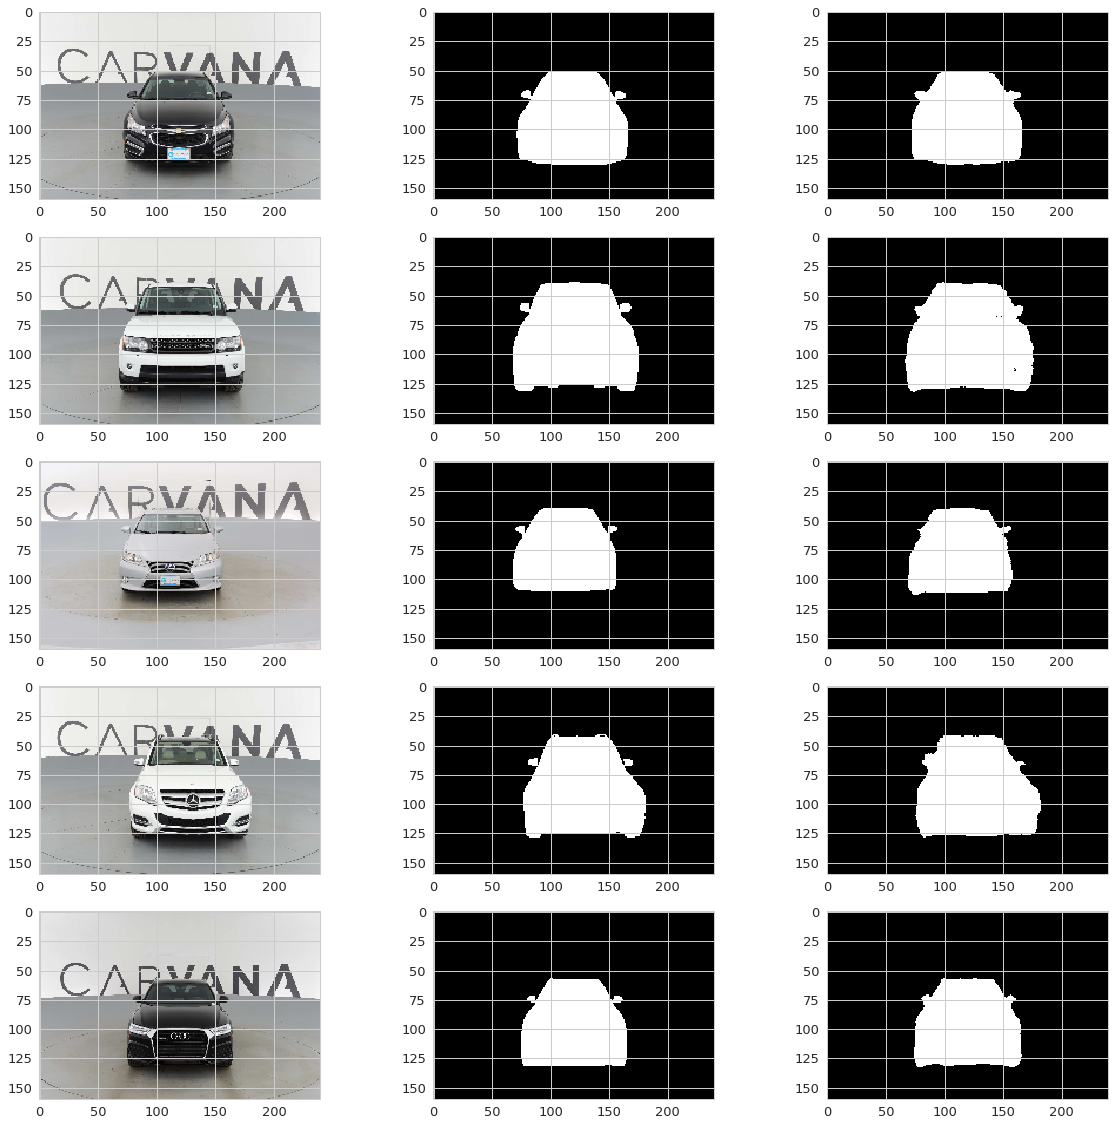

In [17]:
fig, ax = plt.subplots(5, 3, figsize=(20, 20))
ax = ax.ravel()

for i in range(5):
    x = X_val[i]
    y = y_val[i]
    y_pred = model.predict(x[None]).squeeze()    
    
    ax[i*3 + 0].imshow((x[...,:3] * X_std[0,...,:3] + X_mean[0,...,:3]) / 255., cmap='gray')
    
    ax[i*3 + 1].imshow(y[..., 0], cmap='gray')
    
    ax[i*3 + 2].imshow(y_pred >= 0.5, cmap='gray')

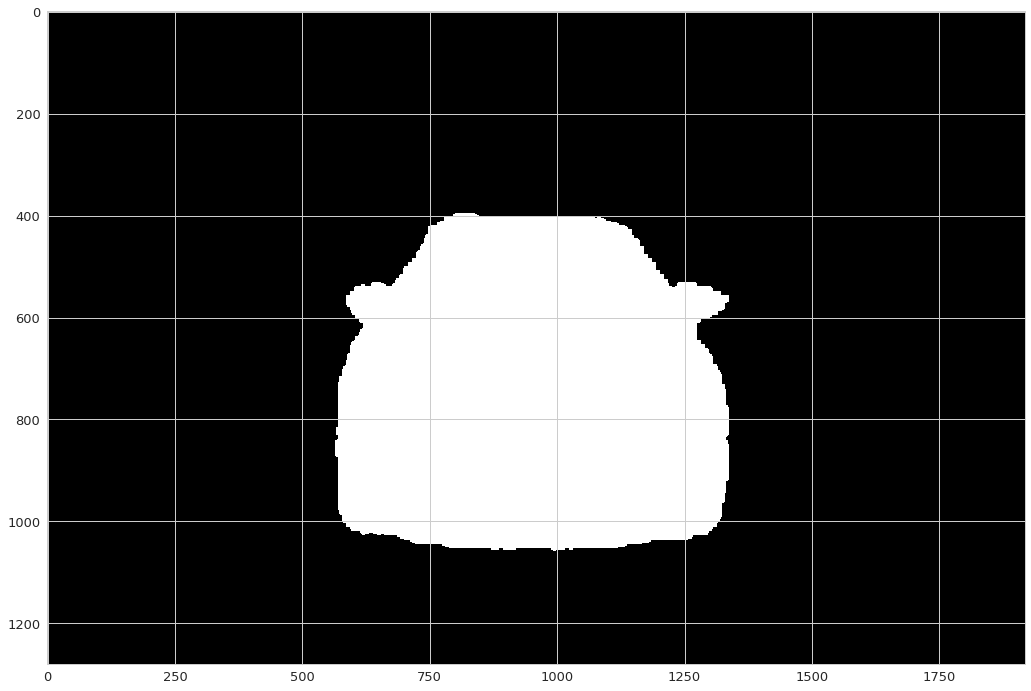

In [18]:
y_pred = model.predict(X_val[0][None]).squeeze()

y_pred_rgb = np.zeros((resize_h, resize_w, 3))
y_pred_rgb[..., 0] = y_pred
y_pred_rgb[..., 1] = y_pred
y_pred_rgb[..., 2] = y_pred

plt.imshow(image.img_to_array(
    image.array_to_img(y_pred_rgb).resize((1918, 1280), Image.BILINEAR))[..., 0] > 0.5, cmap='gray')

# Predict

In [19]:
def load_test_image(id, angle):
    
    dir = test_dir
        
    img = image.load_img(
            dir + '/{0}_{1:02d}.jpg'.format(id, angle),
            target_size=(resize_h, resize_w))
    img = image.img_to_array(img)
    return img

In [20]:
# from here:
# https://www.kaggle.com/stainsby/fast-tested-rle

def rle_encode(mask_image):
    pixels = mask_image.flatten()
    # We avoid issues with '1' at the start or end (at the corners of 
    # the original image) by setting those pixels to '0' explicitly.
    # We do not expect these to be non-zero for an accurate mask, 
    # so this should not harm the score.
    pixels[0] = 0
    pixels[-1] = 0
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 2
    runs[1::2] = runs[1::2] - runs[:-1:2]
    return runs


def rle_to_string(runs):
    return ' '.join(str(x) for x in runs)

In [21]:
test_ids = list(set([name[:12] for name in os.listdir(test_dir)]))#[:10]
n_test = len(test_ids)

with tqdm.tqdm_notebook(total=n_test) as bar:

    with open('pred_rle_{0:02d}.csv'.format(angle), 'w') as f:
        for id in test_ids:

            x = np.empty((resize_h, resize_w, 12), dtype=np.float32)

            imgs = [load_test_image(id, a) for a in range(1, 17)]

            x[..., :9] = np.concatenate([imgs[angle-1], np.mean(imgs, axis=0), np.std(imgs, axis=0)], axis=2)
            del imgs

            x[..., -3:] = y_features

            x -= X_mean[0]
            x /= X_std[0]

            y_pred = model.predict(x[None]).squeeze()
            del x

            y_pred_rgb = np.zeros((resize_h, resize_w, 3))
            y_pred_rgb[..., 0] = y_pred
            y_pred_rgb[..., 1] = y_pred
            y_pred_rgb[..., 2] = y_pred

            y_pred_resized = (image.img_to_array(
                image.array_to_img(y_pred_rgb).resize((1918, 1280), Image.BILINEAR))[..., 0] > 0.5)
            del y_pred
            del y_pred_rgb

            f.write('{0}_{1:02d}.jpg,{2}\n'.format(id, angle, rle_to_string(rle_encode(y_pred_resized))))

            del y_pred_resized

            bar.update()

Widget Javascript not detected.  It may not be installed or enabled properly.
